In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, classification_report

In [2]:
df = pd.read_csv("creditcard.csv")
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


# Show data imbalance

In [3]:
labels=["Genuine","Fraud"]

fraud_or_not = df["Class"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=df['Class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

In [4]:
print('Genuine:', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds:', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

Genuine: 99.83 % of the dataset
Frauds: 0.17 % of the dataset


# Drop duplicates

In [5]:
df.drop_duplicates(inplace=True)
print(f"Duplicated values dropped succesfully: {df.shape}")

Duplicated values dropped succesfully: (283726, 31)


In [6]:
df = df.drop(columns='Time')

# Check outliers

In [7]:
from collections import Counter

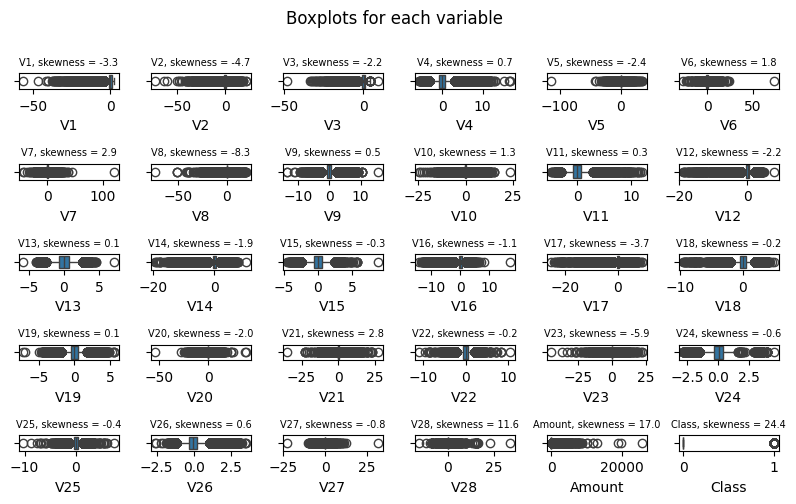

In [8]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(8,5))
    fig.suptitle(suptitle,y=1, size=12)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness = '+str(round(dataset[data].skew(axis = 0, skipna = True),1)), fontsize=7)
        
boxplots_custom(dataset=df, columns_list=df.columns, rows=5, cols=6, suptitle='Boxplots for each variable')
plt.tight_layout()

In [9]:
def IQR_method (df,n,features):

    outlier_list = []
    
    for column in features:
        Q1 = np.percentile(df[column], 25) # 1st quartile (25%)
        Q3 = np.percentile(df[column],75) # 3rd quartile (75%)
        IQR = Q3 - Q1 # Interquartile range (IQR)
        outlier_step = 1.5 * IQR # outlier step

        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [10]:
Outliers_IQR = IQR_method(df,1,df.columns[[-1]])
# df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of outliers is: 473


# Data split

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X = df.iloc[:, :-1] # (283726, 29)
y = df[['Class']] # (283726, 1)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Modelling

In [14]:
class rf:
    def __init__(self, X_resample, y_resample, X_test, y_test, sample_weights):
        if sample_weights == None:
            self.rf_classifier = RandomForestClassifier(random_state=42)
            self.rf_classifier.fit(X_resample, y_resample)
        else:
            self.rf_classifier = RandomForestClassifier(random_state=42, class_weight=None)
            self.rf_classifier.fit(X_resample, y_resample, sample_weight=sample_weights)
        self.y_pred = self.rf_classifier.predict(X_test)
        self.cm = confusion_matrix(y_test, self.y_pred)
        self.rf_Recall = recall_score(y_test, self.y_pred)
        self.rf_Precision = precision_score(y_test, self.y_pred)
        self.rf_f1 = f1_score(y_test, self.y_pred)
        self.rf_accuracy = accuracy_score(y_test, self.y_pred)
        self.fpr = self.cm[0, 1] / (self.cm[0, 1] + self.cm[0, 0])
        self.fnr = self.cm[1, 0] / (self.cm[1, 0] + self.cm[1, 1])

# Method 1: undersampling

In [16]:
from imblearn.under_sampling import RandomUnderSampler

In [17]:
ros = RandomUnderSampler(random_state=42)
X_under, y_under = ros.fit_resample(X_train, y_train)

In [18]:
print('Genuine:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100, 2), '% of the dataset')
print('Frauds:', y_under.value_counts()[1], '/', round(y_under.value_counts()[1]/len(y_under) * 100, 2), '% of the dataset')

Genuine: 339 / 50.0 % of the dataset
Frauds: 339 / 50.0 % of the dataset


In [19]:
un = rf(X_under, y_under, X_test, y_test, sample_weights=None)

c:\Users\citioplab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [20]:
un.rf_accuracy

0.975915787495007

In [21]:
un.fpr

0.023922150051774452

In [22]:
un.fnr

0.12686567164179105

In [23]:
un.rf_f1

0.10245183887915937

In [55]:
un.rf_Recall

0.8731343283582089

In [56]:
un.rf_Precision

0.05441860465116279

# Method2: Tomek link

In [24]:
from imblearn.under_sampling import TomekLinks

In [25]:
tl = TomekLinks()
X_tomek, y_tomek = tl.fit_resample(X_train, y_train)

In [26]:
print('Genuine:', y_tomek.value_counts()[0], '/', round(y_tomek.value_counts()[0]/len(y_tomek) * 100,2), '% of the dataset')
print('Frauds:', y_tomek.value_counts()[1], '/',round(y_tomek.value_counts()[1]/len(y_tomek) * 100,2), '% of the dataset')

Genuine: 198247 / 99.83 % of the dataset
Frauds: 339 / 0.17 % of the dataset


In [27]:
tomek = rf(X_tomek, y_tomek, X_test, y_test, sample_weights=None)

c:\Users\citioplab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [28]:
tomek.rf_accuracy

0.999530064146244

In [29]:
tomek.fpr

5.88346041607832e-05

In [30]:
tomek.fnr

0.26119402985074625

In [31]:
tomek.rf_f1

0.8319327731092437

In [53]:
tomek.rf_Recall

0.7388059701492538

In [54]:
tomek.rf_Precision

0.9519230769230769

# Method3: ADASYN

In [32]:
from imblearn.over_sampling import ADASYN

In [33]:
adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = adasyn.fit_resample(X_train, y_train)

In [34]:
print('Genuine:', y_adasyn.value_counts()[0], '/', round(y_adasyn.value_counts()[0]/len(y_adasyn) * 100, 2), '% of the dataset')
print('Frauds:', y_adasyn.value_counts()[1], '/', round(y_adasyn.value_counts()[1]/len(y_adasyn) * 100, 2), '% of the dataset')

Genuine: 198269 / 50.0 % of the dataset
Frauds: 198294 / 50.0 % of the dataset


In [35]:
adasyn = rf(X_adasyn, y_adasyn, X_test, y_test, sample_weights=None)

c:\Users\citioplab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [36]:
adasyn.rf_accuracy

0.9995065673535563

In [37]:
adasyn.fpr

0.000164736891650193

In [38]:
adasyn.fnr

0.208955223880597

In [39]:
adasyn.rf_f1

0.8346456692913385

In [51]:
adasyn.rf_Recall

0.7910447761194029

In [52]:
adasyn.rf_Precision

0.8833333333333333

# Method4: SMOTE

In [40]:
from imblearn.over_sampling import SMOTE

In [41]:
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

In [42]:
print('Genuine:', y_smote.value_counts()[0], '/', round(y_smote.value_counts()[0]/len(y_smote) * 100,2), '% of the dataset')
print('Frauds:', y_smote.value_counts()[1], '/',round(y_smote.value_counts()[1]/len(y_smote) * 100,2), '% of the dataset')

Genuine: 198269 / 50.0 % of the dataset
Frauds: 198269 / 50.0 % of the dataset


In [43]:
sm = rf(X_smote, y_smote, X_test, y_test, sample_weights=None)

c:\Users\citioplab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



In [44]:
sm.rf_accuracy

0.9995065673535563

In [45]:
sm.fpr

0.00017650381248234963

In [46]:
sm.fnr

0.20149253731343283

In [47]:
sm.rf_f1

0.8359374999999999

In [57]:
sm.rf_Recall   

0.7985074626865671

In [58]:
sm.rf_Precision

0.8770491803278688

# Different ratios

In [48]:
oversampling_ratios = np.arange(0.1, 1.1, 0.1)

# Lists to store FPR and FNR for each oversampling ratio
fpr_list, fnr_list, f1_list, precision_list, recall_list = [], [], [], [], []

for ratio in oversampling_ratios:
    ros = RandomUnderSampler(random_state=42, sampling_strategy=ratio)
    X_under, y_under = ros.fit_resample(X_train, y_train)

    un_temp = rf(X_under, y_under, X_test, y_test, sample_weights=None)
    cm = un_temp.cm

    # Calculate False Positive Rate (FPR) and False Negative Rate (FNR)
    fpr = cm[0, 1] / (cm[0, 1] + cm[0, 0])
    fnr = cm[1, 0] / (cm[1, 0] + cm[1, 1])

    fpr_list.append(fpr)
    fnr_list.append(fnr)
    f1_list.append(un_temp.rf_f1)
    precision_list.append(un_temp.rf_Precision)
    recall_list.append(un_temp.rf_Recall)

c:\Users\citioplab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\Users\citioplab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\Users\citioplab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().

c:\Users\citioplab\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for 

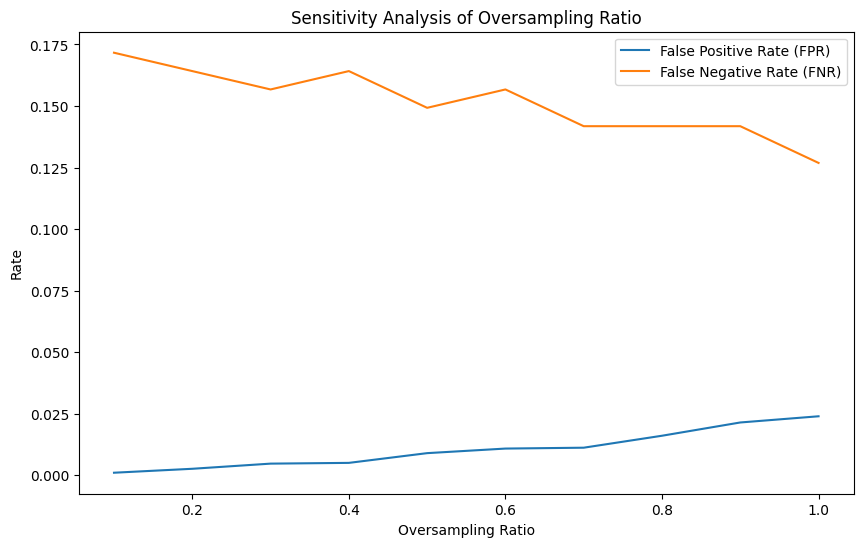

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(oversampling_ratios, fpr_list, label='False Positive Rate (FPR)')
plt.plot(oversampling_ratios, fnr_list, label='False Negative Rate (FNR)')
plt.xlabel('Oversampling Ratio')
plt.ylabel('Rate')
plt.title('Sensitivity Analysis of Oversampling Ratio')
plt.legend()
plt.show()

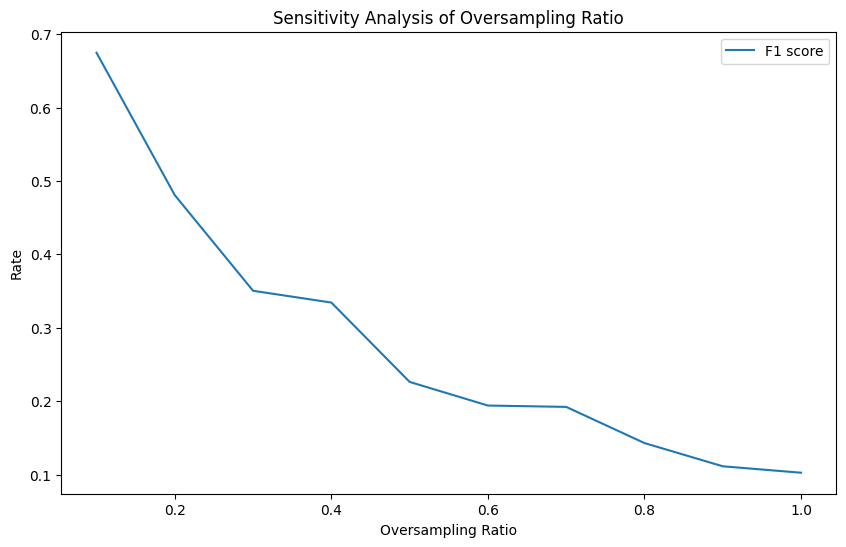

In [59]:
plt.figure(figsize=(10, 6))
plt.plot(oversampling_ratios, f1_list, label='F1 score')
plt.xlabel('Oversampling Ratio')
plt.ylabel('Rate')
plt.title('Sensitivity Analysis of Oversampling Ratio')
plt.legend()
plt.show()

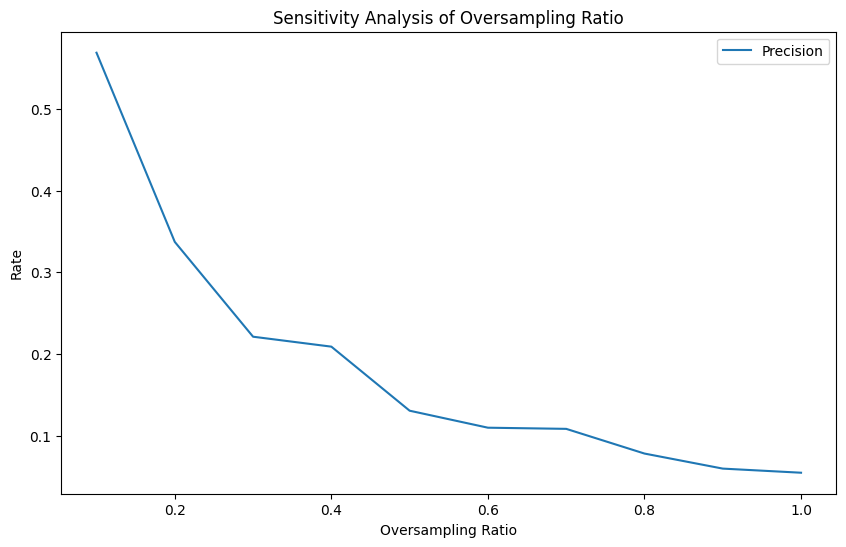

In [60]:
plt.figure(figsize=(10, 6))
plt.plot(oversampling_ratios, precision_list, label='Precision')
plt.xlabel('Oversampling Ratio')
plt.ylabel('Rate')
plt.title('Sensitivity Analysis of Oversampling Ratio')
plt.legend()
plt.show()

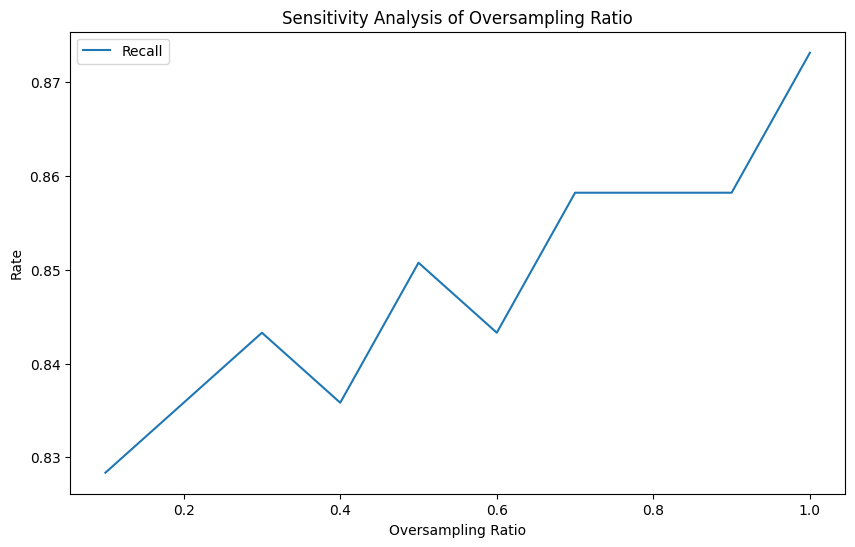

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(oversampling_ratios, recall_list, label='Recall')
plt.xlabel('Oversampling Ratio')
plt.ylabel('Rate')
plt.title('Sensitivity Analysis of Oversampling Ratio')
plt.legend()
plt.show()

## all plot

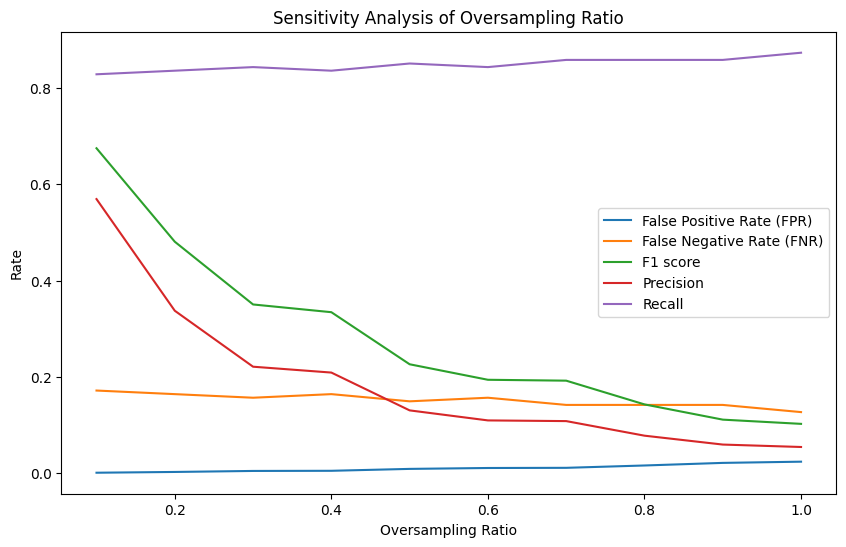

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(oversampling_ratios, fpr_list, label='False Positive Rate (FPR)')
plt.plot(oversampling_ratios, fnr_list, label='False Negative Rate (FNR)')
plt.plot(oversampling_ratios, f1_list, label='F1 score')
plt.plot(oversampling_ratios, precision_list, label='Precision')
plt.plot(oversampling_ratios, recall_list, label='Recall')
plt.xlabel('Oversampling Ratio')
plt.ylabel('Rate')
plt.title('Sensitivity Analysis of Oversampling Ratio')
plt.legend()
plt.show()